In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import transforms

import numpy as np
import os

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
config = {}
config['img_size'] = 256  # 64, 128, 256, 512 

## Images

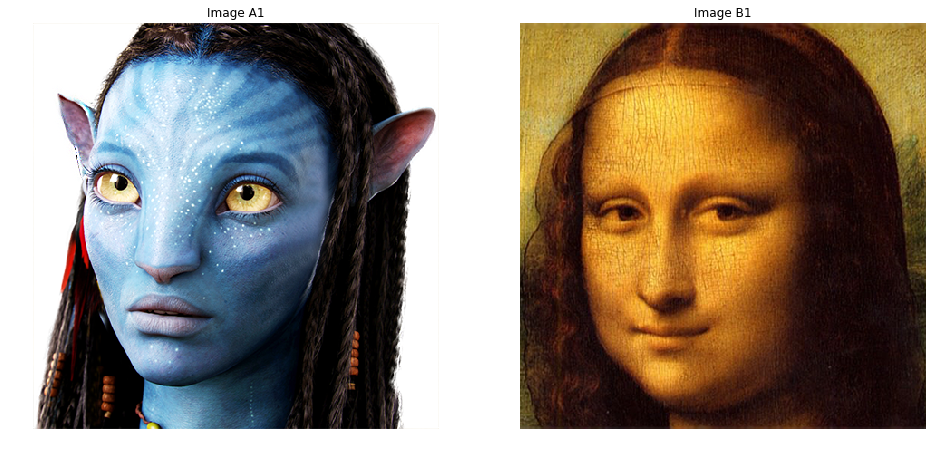

In [2]:
A1 = Image.open(os.path.join('Images', "avatar.png"))
B1 = Image.open(os.path.join('Images', "joconde.png"))

plt.figure(figsize=(16, 12))

plt.subplot(121)
plt.imshow(np.asarray(A1))
plt.title("Image A1")
plt.axis("off")

plt.subplot(122)
plt.imshow(np.asarray(B1))
plt.title("Image B1")
plt.axis("off")
plt.show()

## Pre and Post-Processing

In [3]:
# Preprocessing
prep = transforms.Compose([transforms.Scale(config['img_size']),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1,1,1]), #subtract imagenet mean
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])


# Postprocessing
postpA = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1,1,1]), #add imagenet mean
                           ])

## Model

In [4]:
# VGG implementation (taken from github : leongatys/PytorchNeuralStyleTransfer)
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [5]:
def build_model(path):
    # Instanciates the model
    vgg = VGG()

    # Load the parameters saved in vgg_conv.pth
    vgg.load_state_dict(torch.load(path))

    # Freezes the model
    for param in vgg.parameters():
        param.requires_grad = False

    # Put the model on GPU    
    if torch.cuda.is_available():
        vgg.cuda()
    
    return vgg

## Feedforward VGG for initialization

In [6]:
def get_featureMaps(A1, B1, model):
    """ Feeds content and style images through VGG and get their feature maps. A1 and B1 are PIL images."""
    # Create a list of images, ordered as [content_image, style_image]
    imgs = [A1, B1]

    # Preprocess the images, converts them to autograd.Variable and put on GPU if available
    imgs_torch = [prep(img) for img in imgs]
    if torch.cuda.is_available():
        imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
    else:
        imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]

    # Feed the images through VGG, get their feature maps, and put them in dictionnaries for more clarity
    Layers = [1, 2, 3, 4, 5]

    FeatureMaps_A1 = {L:F for L,F in zip(Layers, model(imgs_torch[0], ['r11','r21','r31','r41','r51']))}
    FeatureMaps_B1 = {L:F for L,F in zip(Layers, model(imgs_torch[1], ['r11','r21','r31','r41','r51']))}
    
    return FeatureMaps_A1, FeatureMaps_B1

### To Visualize

Shows the 9 first feature maps for A1 and B1 at layer L=1 of VGG

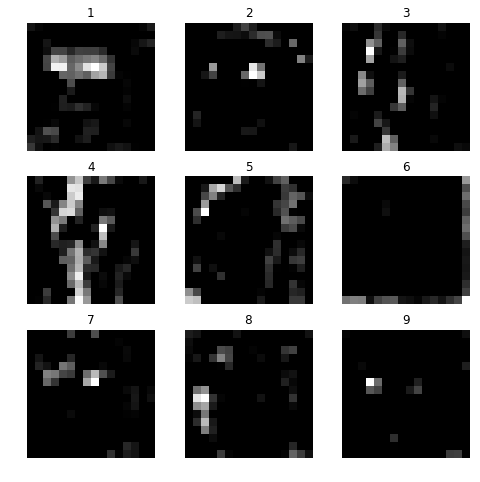

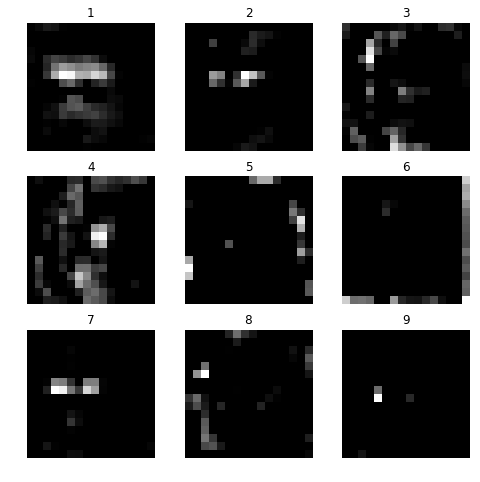

In [8]:
# FeatureMaps_A1                        : a Dictionnary
# FeatureMaps_A1[1]                     : a autograd.Variable
# FeatureMaps_A1[1].data                : a pytorch Tensor of shape [batch, channels, heigth, width] where batch=1
# FeatureMaps_A1[1].data[0].cpu()       : a pytorch Tensor of shape [channels, heigth, width]
# postpA(...)                           : removes imageNet mean
# np.transpose(X, axes=(1,2,0))         : swap axes from shape [channels, heigth, width] to [heigth, width, channels]

A1_feature_maps_L1 = np.transpose(postpA(FeatureMaps_A1[1].data[0].cpu()).numpy(), axes=(1,2,0))
B1_feature_maps_L1 = np.transpose(postpA(FeatureMaps_B1[1].data[0].cpu()).numpy(), axes=(1,2,0))

plt.figure(figsize=(8, 8))
for f in range(9):
    plt.subplot(3,3,f+1)
    plt.imshow(A1_feature_maps_L1[:,:,f], cmap='gray')
    plt.title(str(f+1))
    plt.axis("off")
plt.show()

plt.figure(figsize=(8, 8))
for f in range(9):
    plt.subplot(3,3,f+1)
    plt.imshow(B1_feature_maps_L1[:,:,f], cmap='gray')
    plt.title(str(f+1))
    plt.axis("off")
plt.show()

# Main Code - Deep Image Analogy

This is just a squeleton for the final code and is by no means ready to run :)

In [12]:
# Builds the model (on GPU if available)
vgg = build_model(path=os.path.join('Model', 'vgg_conv.pth'))

# Get the feature maps for reference images
FeatureMaps_A1, FeatureMaps_B1 = get_featureMaps(A1, B1, model=vgg)

# Initialize latent images representations
FeatureMaps_A2 = {}
FeatureMaps_B2 = {}

FeatureMaps_A2[5] = FeatureMaps_A1[5]
FeatureMaps_B2[5] = FeatureMaps_B1[5]

# Other initializations
NNFs_ab = {}
NNFs_ba = {}

R_A2 = {}
R_B2 = {}

# MAIN LOOP
for L in range(5,0,-1):
    # NNF search
    NNFs_ab[L] = patchMatch.computeNNF(...)
    NNFs_ba[L] = patchMatch.computeNNF(...)

    if L > 1:
        # Reconstruction for A2
        Warped_FeatureMaps_A2 = patchMatch.warp(FeatureMaps_B1[L], NNF_ab[L])
        R_A2[L-1] = reconstruction.deconvolve(...)
        FeatureMaps_A2[L-1] = blend(F_A1[L-1], R_A2[L-1])

        # Reconstruction for B2
        Warped_FeatureMaps_B2 = patchMatch.warp(FeatureMaps_A1[L], NNF_ba[L])
        R_B2[L-1] = reconstruction.deconvolve(...)
        FeatureMaps_B2[L-1] = blend(F_B1[L-1], R_B2[L-1])
        
        # NNF upsampling
        NNF_ab[L-1] = upsample(NNF_ba[L])
        NNF_ba[L-1] = upsample(NNF_ba[L])

NameError: name 'build_model' is not defined